# Final
## Steve Cheney
### RBIF110



In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import pubchempy as pcp

import requests
import time

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

## Data Setup

In [2]:
alz_library_file = "Drugs.csv"
try:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="latin-1")

alz_lib = alz_lib.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']).rename(columns={"Canonical SMILES": "SMILES"})

##########################################################

def get_smiles(pubchem_cid):
    try:
        compound = pcp.Compound.from_cid(pubchem_cid)  # Fetch compound from CID
        return compound.isomeric_smiles  # Extract SMILES string
    except:
        return None  # Return None if CID is invalid or not found

cnss_library_file = "cns_simulants.csv"
try:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="latin-1")

cnss_lib["SMILES"] = cnss_lib["PubChem CID"].apply(get_smiles)

cnss_lib = cnss_lib.drop_duplicates(subset=["PubChem CID"])
cnss_lib = cnss_lib.reset_index(drop=True)

##########################################################

rep_library_file = "repurposing_samples.txt"
try:
    rep_lib = pd.read_csv(rep_library_file, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    rep_lib = pd.read_csv(rep_library_file, sep="\t", encoding="latin-1")

rep_lib.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id
0,BRD-K76022557-003-28-9,(R)-(-)-apomorphine,0,98.90,MedChemEx,HY-12723A,Apomorphine (hydrochloride hemihydrate),267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
1,BRD-K76022557-003-02-7,(R)-(-)-apomorphine,0,97.34,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
2,BRD-K76022557-003-29-9,(R)-(-)-apomorphine,0,97.36,Tocris,2073,(R)-(-)-Apomorphine hydrochloride,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
3,BRD-K76022557-001-03-9,(R)-(-)-apomorphine,0,95.80,Selleck,S4350,R-(-)-Apomorphine HCl Hemihydrate,267.126,CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31,VMWNQDUVQKEIOC-CYBMUJFWSA-N,6005.0,NaN
4,BRD-K75516118-001-04-1,(R)-(-)-rolipram,0,93.92,Tocris,1349,(R)-(-)-Rolipram,275.152,COc1ccc(cc1OC1CCCC1)[C@@H]1CNC(=O)C1,HJORMJIFDVBMOB-LBPRGKRZSA-N,448055.0,NaN


In [11]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version.

    Args:
        - smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle missing values or non-string input
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None

    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # Check for invalid SMILES
        return None
    
    try:
        # Choose the largest fragment if the molecule has multiple components
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        mol = largest_Fragment.choose(mol)  

        # Generate canonical SMILES
        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)

        return canonical_smiles

    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return None

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset
    
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

def calculate_similarity(df, query_smiles):
    """
    Calculate Tanimoto similarity between a query SMILES and a dataframe of molecules

    Args:
        - df: pd.Dataframe, DataFrame containing a 'SMILES' column
        - query_smiles: str, Query molecule in SMILES format

    Returns:
        pd.DataFrame
    """

    df_copy = df.copy()

    # Convert query SMILES to RDKit Mol object
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        raise ValueError("Invalid SMILES string provided for query.")

    # Generate fingerprint for query molecule
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024)

    # Compute similarity scores
    similarity_scores = [
        (DataStructs.TanimotoSimilarity(query_fp, AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
         if mol is not None else None)
        for mol in df_copy['standardized_mol']
    ]

    # Add similarity scores to dataframe
    df_copy['similarity'] = similarity_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return df_sorted

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None
    
def dataframe_setup(df, smiles_col, mol_col):
    # Clean the data to ignore any NaN smiles values and subset data if needed
    df = clean_df_and_create_mol_col(df, smiles_col, mol_col)
    df['standardized_mol'] = df[smiles_col].apply(get_standard_mol)
    df['canonical_smiles'] = df[smiles_col].apply(standardize_smiles)
    df['fingerprint'] = df['standardized_mol'].apply(get_fingerprint)

    descriptor_data = df["standardized_mol"].apply(calculate_descriptors)

    filtered_data = [d for d in descriptor_data if d is not None]
    descriptor_df = pd.DataFrame(filtered_data)
    df = pd.concat([df, descriptor_df], axis=1)

    df = df.dropna(subset=['standardized_mol', 'canonical_smiles', 'fingerprint', "Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"])
    df = df[(df['standardized_mol'] != '') & (df['canonical_smiles'] != '') & (df['fingerprint'] != '')]
    
    print(df.shape)
    print(df.head())
    return df


In [144]:
alz_lib = dataframe_setup(alz_lib, 'SMILES', 'mol')
cnss_lib = dataframe_setup(cnss_lib, 'SMILES', 'mol')
rep_lib = dataframe_setup(rep_lib, 'smiles', 'mol')

(20203, 21)
                 broad_id           pert_iname  qc_incompatible  purity  \
0  BRD-K76022557-003-28-9  (R)-(-)-apomorphine                0   98.90   
1  BRD-K76022557-003-02-7  (R)-(-)-apomorphine                0   97.34   
2  BRD-K76022557-003-29-9  (R)-(-)-apomorphine                0   97.36   
3  BRD-K76022557-001-03-9  (R)-(-)-apomorphine                0   95.80   
4  BRD-K75516118-001-04-1     (R)-(-)-rolipram                0   93.92   

      vendor catalog_no                              vendor_name  \
0  MedChemEx  HY-12723A  Apomorphine (hydrochloride hemihydrate)   
1     Tocris       2073        (R)-(-)-Apomorphine hydrochloride   
2     Tocris       2073        (R)-(-)-Apomorphine hydrochloride   
3    Selleck      S4350        R-(-)-Apomorphine HCl Hemihydrate   
4     Tocris       1349                         (R)-(-)-Rolipram   

   expected_mass                                  smiles  \
0        267.126  CN1CCc2cccc-3c2[C@H]1Cc1ccc(O)c(O)c-31   
1       

In [9]:
def plot_property_distributions(df,id):
    """
    Generate jitter plots for the distribution of selected molecular properties
    """
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, prop in enumerate(properties):
        sns.stripplot(x=id, y=prop, data=df, jitter=True, alpha=0.6, color="blue", ax=axes[i])        
        axes[i].set_xticks([])  # Remove x-axis labels
        axes[i].set_title(f"Distribution of {prop}")
        axes[i].set_ylabel(prop)
        axes[i].set_xlabel("")

    plt.tight_layout()
    plt.show()

#plot_property_distributions(alz_lib, id="IPAD_DB_ID")
#plot_property_distributions(cnss_lib, id="PubChem CID")
#plot_property_distributions(rep_lib, id="broad_id")


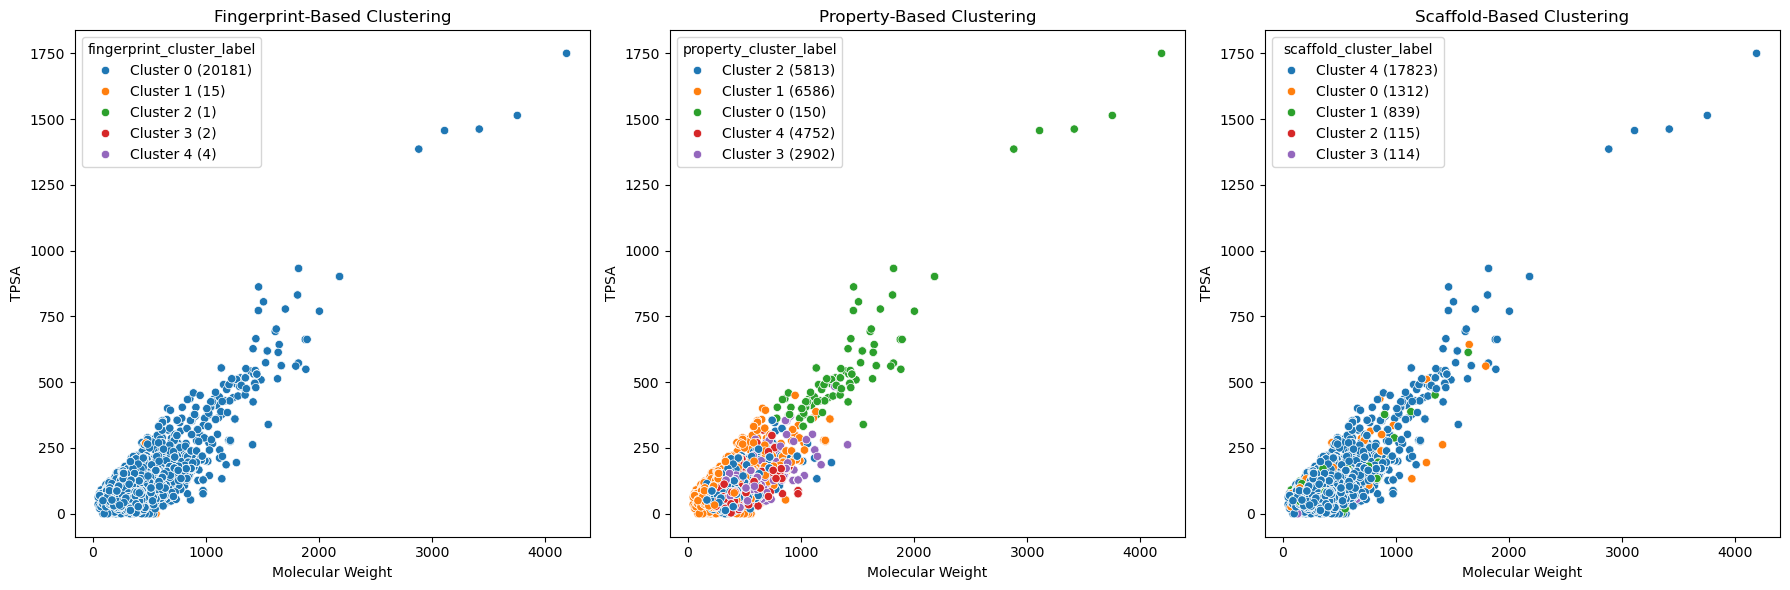

In [145]:
def cluster_by_fingerprint(df, n_clusters=5):
    """Hierarchical clustering based on Tanimoto similarity."""
    
    # Remove molecules with missing fingerprints
    df = df[df['fingerprint'].notna()].copy()
    fingerprints = df['fingerprint'].tolist()
    num_mols = len(fingerprints)

    if num_mols == 0:
        raise ValueError("No valid fingerprints available for clustering!")

    # Compute Tanimoto similarity matrix
    similarity_matrix = np.zeros((num_mols, num_mols))
    for i in range(num_mols):
        for j in range(i, num_mols):
            if fingerprints[i] is not None and fingerprints[j] is not None:
                sim = Chem.DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            else:
                sim = 0  # Default similarity for None cases
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance

    # Use metric instead of affinity
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    df['fingerprint_cluster'] = clustering.fit_predict(distance_matrix)
    return df


def cluster_by_properties(df, n_clusters=5):
    """K-means clustering on normalized molecular properties."""
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
    scaler = MinMaxScaler()
    normalized_props = scaler.fit_transform(df[properties])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['property_cluster'] = kmeans.fit_predict(normalized_props)
    return df

def get_murcko_scaffold(mol):
    """Extract Murcko scaffold."""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol) if mol else None

def cluster_by_scaffold(df, n_scaff=4):
    """Clusters molecules by Murcko scaffold, grouping common scaffolds separately."""
    df['scaffold'] = df['standardized_mol'].apply(get_murcko_scaffold)
    scaffold_counts = Counter(df['scaffold'].dropna())
    top_scaffolds = [scaffold for scaffold, count in scaffold_counts.most_common(n_scaff)]  # Top n scaffolds

    def assign_scaffold_cluster(scaffold):
        return top_scaffolds.index(scaffold) if scaffold in top_scaffolds else len(top_scaffolds)  # Assign 'other'

    df['scaffold_cluster'] = df['scaffold'].apply(assign_scaffold_cluster)
    return df

def main_clustering_pipeline(df, n_clust=5):
    """Runs all clustering methods, computes similarity scores, and visualizes results."""
    df = cluster_by_fingerprint(df, n_clust)
    df = cluster_by_properties(df, n_clust)
    df = cluster_by_scaffold(df, n_clust-1)

    # Plot clustering results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cluster_types = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster']
    titles = ["Fingerprint-Based Clustering", "Property-Based Clustering", "Scaffold-Based Clustering"]

    for i, cluster_col in enumerate(cluster_types):
        # Count occurrences of each cluster
        cluster_counts = df[cluster_col].value_counts().to_dict()
        # Rename clusters
        df[f"{cluster_col}_label"] = df[cluster_col].apply(
            lambda x: f"Cluster {x} ({cluster_counts[x]})"
        )

        df = df.loc[:, ~df.columns.duplicated()]

        sns.scatterplot(
            x=df['Molecular_Weight'], 
            y=df['TPSA'], 
            hue=df[f"{cluster_col}_label"], 
            palette="tab10", 
            ax=axes[i]
        )

        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Molecular Weight")
        axes[i].set_ylabel("TPSA")

    plt.tight_layout()
    plt.show()
    
    return df

alz_cluster = main_clustering_pipeline(alz_lib, n_clust=5)
cnss_cluster = main_clustering_pipeline(cnss_lib, n_clust=5)
rep_cluster = main_clustering_pipeline(rep_lib, n_clust=5)



In [148]:
import gemmi
import py3Dmol
import mols2grid

import numpy as np
import pandas as pd

import shutil
import os

# Define paths
license_src = os.path.abspath("license.lic")  # Path to your existing license file
pymol_license_dir = os.path.expanduser("~/.pymol")  # Default PyMOL license directory

# Ensure the directory exists
os.makedirs(pymol_license_dir, exist_ok=True)

# Copy license file to the expected location
shutil.copy(license_src, os.path.join(pymol_license_dir, "pymol.lic"))

os.environ["PYMOL_LICENSE_FILE"] = os.path.join(pymol_license_dir, "pymol.lic")

In [26]:
!curl -L -o smina.static https://sourceforge.net/projects/smina/files/smina.static/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   585  100   585    0     0   1751      0 --:--:-- --:--:-- --:--:--  1767

100   327  100   327    0     0    590      0 --:--:-- --:--:-- --:--:--   590

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 9622k  100 9622k    0     0  7443k      0  0:00:01  0:00:01 --:--:-- 40.1M


In [213]:
# Define the CIF file path
cif_file = "2DQ7.cif"

# Read the CIF file
cif_doc = gemmi.cif.read(cif_file)
block = cif_doc.sole_block()

# Extract PDB ID
pdb_id = "2DQ7"

# Extract resolution
resolution = None
res_value = block.find_value('_refine.ls_d_res_high')
if res_value and res_value.replace('.', '', 1).isdigit():
    resolution = float(res_value)

# Extract protein and ligand details
structure = gemmi.make_structure_from_block(block)

ligands = set()
chains = set()

for model in structure:
    for chain in model:
        chains.add(chain.name)  # Collect chain names
        for res in chain:
            if res.subchain:  # Ligands typically have a non-empty subchain
                ligands.add(res.name)

# Generate a structured report
report = f"""
# Structural Report: {pdb_id}

## General Information:
- **PDB ID:** {pdb_id}
- **Resolution:** {resolution} Å
- **Number of Chains:** {len(chains)}
- **Chains Present:** {', '.join(sorted(chains))}

## Ligand Information:
- **Bound Ligands:** {', '.join(ligands) if ligands else "None"}

## Summary:
PDB structure {pdb_id} has a resolution of {resolution} Å and contains {len(chains)} chains. 
The structure includes the following bound ligands: {', '.join(ligands) if ligands else "None"}.
This makes it a suitable candidate for further **virtual screening**.

"""

# Save the report to a text file
output_report = "./2DQ7_report.txt"
with open(output_report, "w") as f:
    f.write(report)

# Print confirmation
print(f"Report generated: {output_report}")


Report generated: ./2DQ7_report.txt


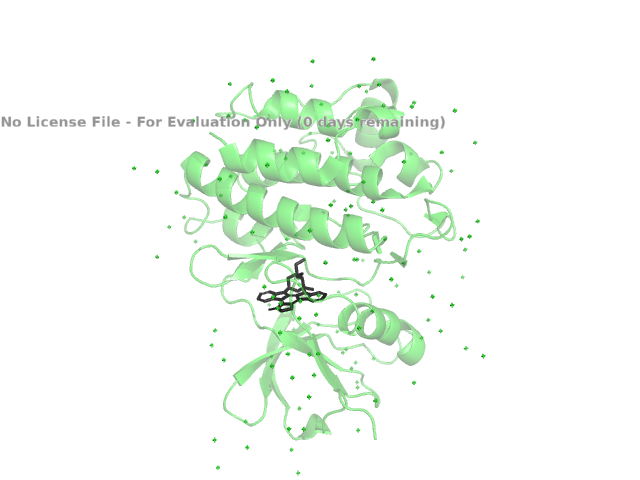

In [214]:
from pymol import cmd
from IPython.display import Image

cmd.reinitialize()
cmd.fetch("2DQ7")
cmd.orient("2DQ7")

# Select and show only Chain A
cmd.select("chainA", "2DQ7 and chain A")

cmd.rotate("z", "270")
cmd.png("2DQ7.png")  # Save image
Image(filename="2DQ7.png", unconfined=True)

cmd.util.cbc()
cmd.png("2DQ7.png")
Image(filename="2DQ7.png", unconfined=True)

cmd.color("black", "organic")
cmd.set("cartoon_transparency", 0.5)
cmd.png("2DQ7.png")
Image(filename="2DQ7.png", unconfined=True)


In [216]:
import gemmi

# Load the CIF file
cif_file = "2DQ7.cif"
cif_doc = gemmi.cif.read(cif_file)
block = cif_doc.sole_block()

# Extract structure
structure = gemmi.make_structure_from_block(block)

# Define ligand interaction distance cutoff (e.g., 5.0Å)
interaction_distance = 5.0

ligand_name = "STU"

# Define the target protein chain (A)
target_chain = "X"

# List of standard amino acids
standard_amino_acids = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL"
}

# Step 1: Identify 4LO ligand atoms
ligand_atoms = []
for model in structure:
    for chain in model:
        for res in chain:
            if res.name == ligand_name:
                for atom in res:
                    ligand_atoms.append(atom.pos)

# Step 2: Find only **unique** protein residues near FAD
binding_residues = set()  # Use a **set** to avoid duplicates

for model in structure:
    for chain in model:
        if chain.name == target_chain:  # Only process Chain A
            for res in chain:
                if res.seqid.num:  # Ensure residue has a valid ID
                    if res.name in standard_amino_acids:  # Ensure it's a protein residue
                        # Check if **any** atom in this residue is within the threshold distance of MLG
                        for atom in res:
                            if any(atom.pos.dist(lig_atom) <= interaction_distance for lig_atom in ligand_atoms):
                                binding_residues.add((res.name, res.seqid.num, chain.name))  # Store unique residues
                                break  # Avoid duplicates

# Step 3: Print the refined FAD-binding residues
if binding_residues:
    print(f"✅ {len(binding_residues)} Unique Protein Residues Interacting with STU in Chain {target_chain} (≤{interaction_distance}Å):")
    for res in sorted(binding_residues, key=lambda x: x[1])[:50]:  # Print first 50 for readability
        print(f"- **Residue:** {res[0]} (ID: {res[1]}), Chain: {res[2]}")
else:
    print(f"❌ No protein residues found within {interaction_distance}Å of STU.")


✅ 21 Unique Protein Residues Interacting with STU in Chain X (≤5.0Å):
- **Residue:** LEU (ID: 17), Chain: X
- **Residue:** GLY (ID: 18), Chain: X
- **Residue:** ASN (ID: 19), Chain: X
- **Residue:** VAL (ID: 25), Chain: X
- **Residue:** ALA (ID: 37), Chain: X
- **Residue:** LYS (ID: 39), Chain: X
- **Residue:** GLU (ID: 54), Chain: X
- **Residue:** VAL (ID: 67), Chain: X
- **Residue:** THR (ID: 82), Chain: X
- **Residue:** GLU (ID: 83), Chain: X
- **Residue:** TYR (ID: 84), Chain: X
- **Residue:** MET (ID: 85), Chain: X
- **Residue:** ASN (ID: 86), Chain: X
- **Residue:** GLY (ID: 88), Chain: X
- **Residue:** SER (ID: 89), Chain: X
- **Residue:** ALA (ID: 134), Chain: X
- **Residue:** ASN (ID: 135), Chain: X
- **Residue:** LEU (ID: 137), Chain: X
- **Residue:** ALA (ID: 147), Chain: X
- **Residue:** ASP (ID: 148), Chain: X
- **Residue:** PHE (ID: 149), Chain: X


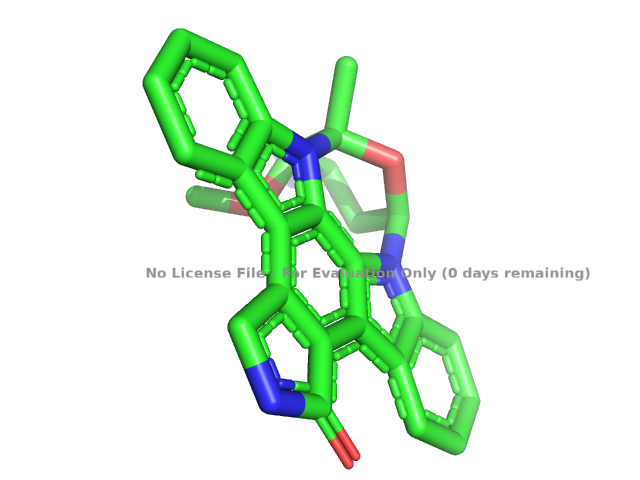

In [219]:
from pymol import cmd
from IPython.display import Image

cmd.reinitialize()
cmd.fetch("2DQ7")
cmd.orient("2DQ7")

# Select and show only Chain X
cmd.select("2DQ7")

# Now we need to split the structure into a ligand and a receptor file (only Chain X)
cmd.select("2DQ7-ligand", "resn STU and chain X")
cmd.select("2DQ7-receptor", "2DQ7 and chain X and not 2DQ7-ligand")

# Save separate files
cmd.save("2DQ7-ligand.pdb", "2DQ7-ligand")
cmd.save("2DQ7-receptor.pdb", "2DQ7-receptor")

# Wipe PyMOL memory and reload the ligand for visualization
cmd.reinitialize()
cmd.load("2DQ7-ligand.pdb")

# Generate ligand image
cmd.png("ligand.png")
Image(filename="ligand.png", unconfined=True)


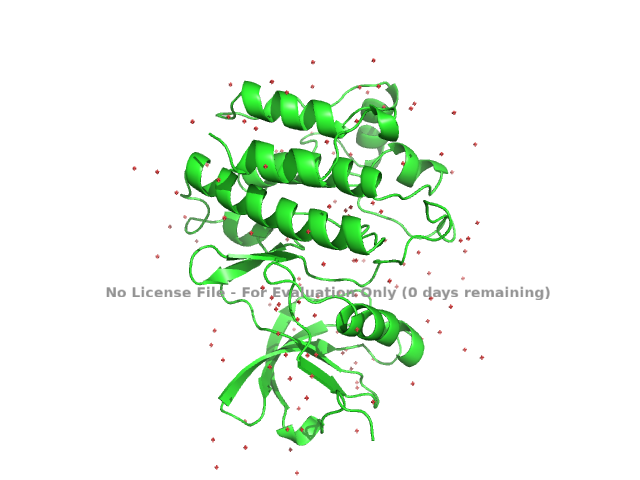

In [220]:
#Now the receptor
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("2DQ7-receptor.pdb")
cmd.orient("2DQ7-receptor")
cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

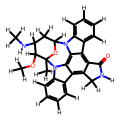

In [222]:
size = (120, 120)

lig = Chem.MolFromSmiles("O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7ccccc67)CC(NC)C8OC)C")
img = Draw.MolToImage(lig, size=size)
lig = Chem.AddHs(lig, addCoords=True) #We need to add hydrogens to the new ligand
Draw.MolToImage(lig, size=size)

In [223]:
AllChem.EmbedMolecule(lig)
AllChem.MMFFOptimizeMolecule(lig)


#Display the result using py3Dmol
mblock = Chem.MolToMolBlock(lig)

view = py3Dmol.view(data=mblock, style={"stick": {}, "sphere": {"scale": 0.3}})
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [226]:
file = Chem.SDWriter('newligand_1.sdf') #create the file
file.write(lig) #write the 3d ligand to the file

['2DQ7-receptor', '2DQ7-ligand', 'newligand_1']


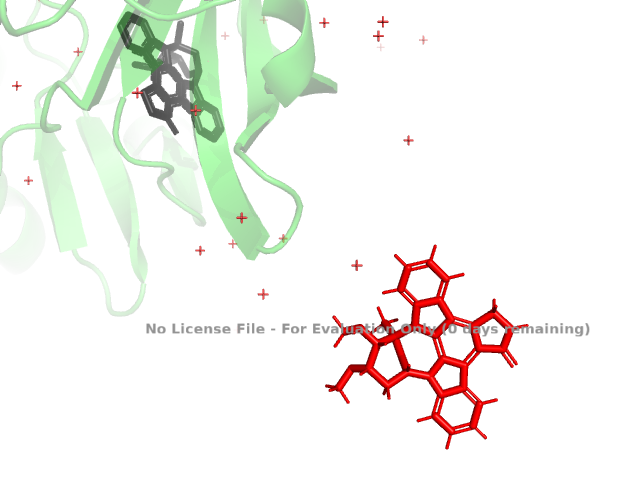

In [227]:
#Lets check the new ligand - so the new ligand should be assigned random coordinates in space. If we load this new one into our previous PDB file, we will see it's somewhere random
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("2DQ7-receptor.pdb")
cmd.load("2DQ7-ligand.pdb")
cmd.color("black","2DQ7-ligand")
cmd.load("newligand_1.sdf")

print(cmd.get_object_list())


cmd.color("red","newligand_1")
cmd.set("cartoon_transparency",0.6)
cmd.select("ligands", "organic")
cmd.zoom("ligands")
#cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

In [228]:
!wsl ./smina.static -r  2DQ7-receptor.pdb -l newligand_1.sdf --autobox_ligand 2DQ7-ligand.pdb -o 2DQ7-ligand-poses.sdf

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -566812820

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


,minimizedAffinity,ID,ROMol
0,-11.20162,,
1,-10.97652,,
2,-10.73957,,
3,-9.99715,,
4,-9.92290,,
5,-9.83044,,
6,-9.73806,,
7,-9.73796,,
8,-9.73409,,

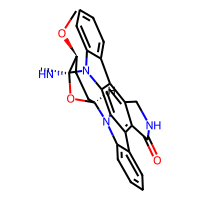
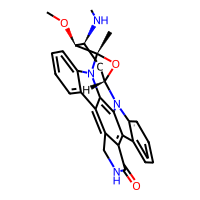
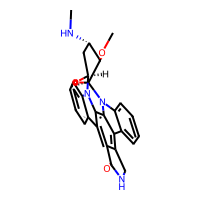
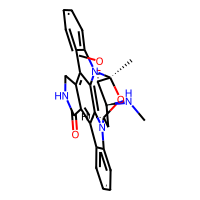
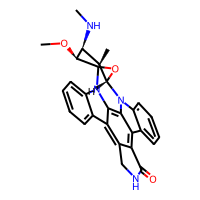
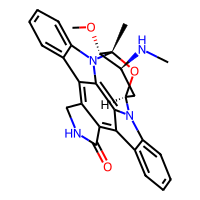
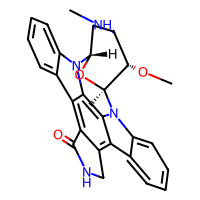
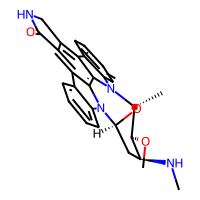
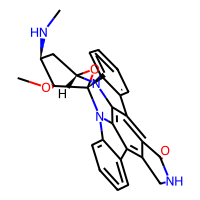

In [229]:
dockedposes = PandasTools.LoadSDF("2DQ7-ligand-poses.sdf")
dockedposes

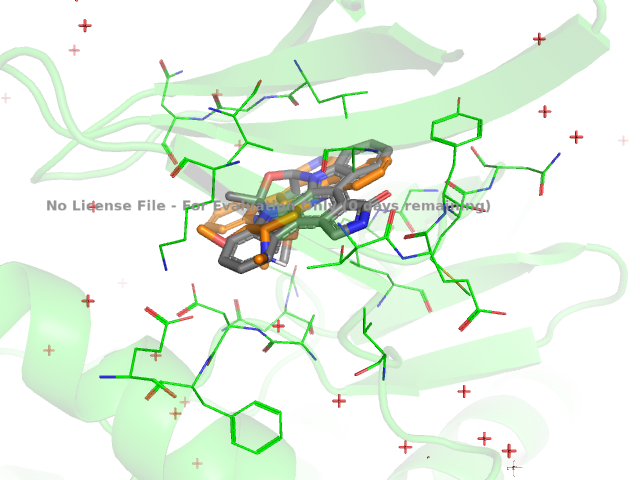

In [230]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("2DQ7-receptor.pdb")
cmd.load("2DQ7-ligand.pdb")
cmd.load("2DQ7-ligand-poses.sdf")


cmd.color("green","2DQ7-receptor") #color the protein cyan
cmd.color("grey", "2DQ7-ligand") #Color the original pose grey
cmd.color("orange", "2DQ7-ligand-poses")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 2DQ7-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")

camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#display the best pose
camera = cmd.get_view()
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

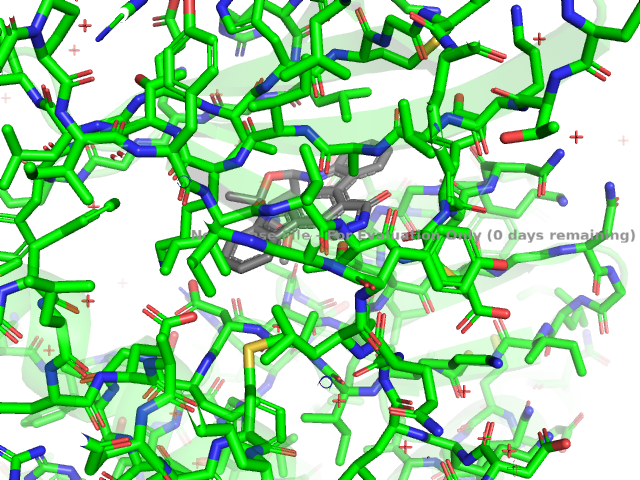

In [231]:
#show all the poses
cmd.set("all_states", 1)
cmd.set_view(camera)
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)
#we can also get individual poses by splitting the poses into individual
cmd.set("all_states",0)
cmd.split_states("2DQ7-ligand-poses")
cmd.get_names()
cmd.get_names()[0]  #The last one in this list is the highest energy
cmd.hide("everything","2DQ7-ligand-poses*") #hide all the poses
best = cmd.get_names()[0]
cmd.show("stick",best)  #Get the last pose, which should be the worst (highest energy)

cmd.set_view(camera)

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

In [232]:
rep_cluster["pubchem_cid"]

0          6005.0
1          6005.0
2          6005.0
3          6005.0
4        448055.0
           ...   
20238     92400.0
20239     92400.0
20240     92400.0
20241     91769.0
20242     91769.0
Name: pubchem_cid, Length: 20203, dtype: float64

In [233]:
data = {
    'pubchem_cid': [44259.0],  # Float representation
    'smiles': ["O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7ccccc67)CC(NC)C8OC)C"]
}

# Create the DataFrame
target_ligand = pd.DataFrame(data)
target_ligand = dataframe_setup(target_ligand, 'smiles', 'mol')
target_ligand

(1, 11)
   pubchem_cid                                             smiles  \
0      44259.0  O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...   

                                                 mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001740D1...   

                                    standardized_mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001740D1...   

                                    canonical_smiles  \
0  CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...   

                                         fingerprint  Molecular_Weight  \
0  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           466.541   

   Rotatable_Bonds  Aromatic_Bonds  ClogP   TPSA  
0                2               5  4.354  69.45  


,pubchem_cid,smiles,mol,standardized_mol,canonical_smiles,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
0,44259.0,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,<rdkit.Chem.rdchem.Mol object at 0x000001740D1...,<rdkit.Chem.rdchem.Mol object at 0x000001740D1...,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,2,5,4.354,69.45


In [234]:
import requests

CHEMBL_API_URL = "https://www.ebi.ac.uk/chembl/api/data/activity.json"

def fetch_alk_binders(max_ic50_um = 15, chembl_api = CHEMBL_API_URL):
    ic50_molar = max_ic50_um * 1e-6
    pchembl = -np.log10(ic50_molar)
    params = {
        "target_chembl_id": "CHEMBL1841",
        "standard_type": "IC50",
        "pchembl_value__gte": pchembl,
        "limit": 1000
    }
    response = requests.get(chembl_api, params=params)
    if response.status_code == 200:
        data = response.json()
        if "activities" not in data:
            print("No data found.")
            return None
        compounds = [
            {
                "ChEMBLID": entry["molecule_chembl_id"],
                "Canonical SMILES": entry.get("canonical_smiles", "N/A"),
                "IC50 (uM)": float(entry["standard_value"]) / 1000 if entry.get("standard_units") == "nM" else entry.get("standard_value", "N/A"),
                "Standard Value (nM)": entry["standard_value"],
                "pChEMBL Value": entry.get("pchembl_value", "N/A"),
                "Target ChEMBL ID": entry["target_chembl_id"],
            }
            for entry in data["activities"]
        ]
        chembl_df = pd.DataFrame(compounds)
        return chembl_df

alk_binders_df = fetch_alk_binders()
alk_binders_df

,ChEMBLID,Canonical SMILES,IC50 (uM),Standard Value (nM),pChEMBL Value,Target ChEMBL ID
0,CHEMBL322395,COc1cc(Nc2c(C#N)cnc3cc(-c4ccc(CN5CCOCC5)cc4)cc...,1.170,1170.0,5.93,CHEMBL1841
1,CHEMBL317821,COc1cc(Nc2c(C#N)cnc3cc(-c4ccc(CN5CCN(C)CC5)cc4...,0.830,830.0,6.08,CHEMBL1841
2,CHEMBL303786,COc1cc(Nc2c(C#N)cnc3cc(-c4csc(CN5CCN(C)CC5)c4)...,0.580,580.0,6.24,CHEMBL1841
3,CHEMBL60391,COc1cc(Nc2c(C#N)cnc3cc(-c4cc(CN5CCN(C)CC5)cs4)...,0.630,630.0,6.20,CHEMBL1841
4,CHEMBL288441,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,0.410,410.0,6.39,CHEMBL1841
...,...,...,...,...,...,...
249,CHEMBL406845,CC(C)(C)n1nc(-c2ccc(Cl)cc2)c2c(N)ncnc21,0.005,5.0,8.30,CHEMBL1841
250,CHEMBL5417444,COc1cc(-n2cnc3cc(-c4cnn(C)c4)ccc32)cc(OC(F)F)c...,0.447,447.0,6.35,CHEMBL1841
251,CHEMBL466397,CCc1cc(Nc2nccc(-c3c(-c4ccc(OC)c(C(=O)Nc5c(F)cc...,6.300,6300.0,5.20,CHEMBL1841
252,CHEMBL209148,COc1cc(C)c(Sc2cnc(NC(=O)c3ccc(CNC(C)C(C)(C)C)c...,1.100,1100.0,5.96,CHEMBL1841


In [235]:
#Take only rows with pChembl > 8
alk_binders_df = alk_binders_df.rename(columns={"Canonical SMILES": "Smiles"})
alk_binders_df["pChEMBL Value"] = pd.to_numeric(alk_binders_df["pChEMBL Value"], errors='coerce')

actives=pd.DataFrame(alk_binders_df.loc[alk_binders_df['pChEMBL Value'] > 8]['Smiles'])
cognate=pd.DataFrame({"Smiles":["O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7ccccc67)CC(NC)C8OC)C"]}) #STU

actives=pd.concat([actives,cognate]) # Make sure that we add the cognate ligand to the actives list


#Lets also compare the similarity with the cognate ligand
from rdkit import DataStructs

fpgen = AllChem.GetMorganGenerator()
query = Chem.MolFromSmiles('O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7ccccc67)CC(NC)C8OC)C')
queryfp = fpgen.GetFingerprint(query)

sim=[]
for x in actives.Smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

actives = pd.DataFrame(actives)
actives["Active"]="True"
actives["Sim"]=sim
actives = actives.rename(columns = {'Smiles':'smiles'}) #adjust capitalization of name
actives=actives.sort_values("Sim",ascending=False)
actives=actives.drop_duplicates(subset='smiles', keep="first")
actives

,smiles,Active,Sim
0,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,True,1.000000
71,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,True,1.000000
183,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,True,0.098684
184,CNC(=O)c1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,True,0.098684
195,COc1cc(-c2nn(CCN3CCC(N(C)C)CC3)c3ncnc(N)c23)cc...,True,0.096970
77,C=CC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,True,0.094203
72,CC1(C)CC(NC(=O)c2cccc(-c3cc4nccc(Nc5cccc(O)c5)...,True,0.087500
199,C=CC(=O)N[C@H]1CC[C@@H](n2nc(-c3ccc(Oc4ccccc4)...,True,0.082278
80,C=CC(=O)Nc1ccc2ncnc(Nc3ccccc3)c2c1,True,0.082090
78,C=CC(=O)Nc1ccc2ncnc(Nc3ccc4ccccc4c3)c2c1,True,0.076923


In [236]:
import requests

# Define file URLs and names
ligand_urls = {
    "sample_one.smi": "http://files.docking.org/2D/CD/CDAC.smi",
    "sample_two.smi": "http://files.docking.org/2D/EF/EFEA.smi",
    "sample_three.smi": "http://files.docking.org/2D/HJ/HJAB.smi"
}

# Download each file
for filename, url in ligand_urls.items():
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise error if request fails
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"✅ Successfully downloaded: {filename}")
    except requests.exceptions.RequestException as e:
        print(f"❌ Failed to download {filename}: {e}")



✅ Successfully downloaded: sample_one.smi
✅ Successfully downloaded: sample_two.smi
✅ Successfully downloaded: sample_three.smi


In [242]:
#OK lets load all of them into a single dataframe
frames = [pd.read_csv('sample_one.smi', sep=" "),
          pd.read_csv('sample_two.smi', sep=" "),
          pd.read_csv('sample_three.smi', sep=" ")]
randoms = pd.concat(frames,ignore_index=True)


smiles_randoms = randoms.copy()
randoms
#Calculate the similarity of the random mols to 4LO
randoms=pd.DataFrame(randoms['smiles'])
randoms=randoms.sample(300)

sim=[]
for x in randoms.smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

randoms["Active"]="False"
randoms["Sim"]=sim
randoms=randoms.sort_values("Sim", ascending=False)
randoms.head()

#For our positives, we will take the 10 most similar rows to the cognate ligand. The assumption here
#is that similar ligands could potentially bind to the same site
activesample=actives.sort_values("Sim", ascending=False)[0:3]
print(activesample)


## OK - we have negatives (random molecules) as sdf, and then some positives as smiles. Lets make a uniform dataframe as all smiles
## We will make a dataframe of 3 positives, and 7 randoms
import random
import numpy as np
vsmols = pd.concat([activesample,randoms.sample(7)])
#Ok now we have a dataframe with some actives and some negatives. Last thing to do is to create a unique ID
number=np.arange(0,len(vsmols)).astype('str')
vsmols["ID"]=np.char.add('Molecule_',number)


#Ok now we need to convert all these SMILES into 3d structures

#write a conversion function to convert SMILES to a 3D structure
def Convert3D(molsmile):
    mol = Chem.MolFromSmiles(molsmile)
    mol = Chem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return mol

minim=[]
for x in vsmols.smiles:
    minim.append(Convert3D(x))

#add the column of minimized structures to our dataframe
vsmols["minim"]=minim

#Write the minimized 3D structures to a file for Smina to dock
from rdkit.Chem import PandasTools

PandasTools.WriteSDF(vsmols, out="dockingligands.sdf",
                     molColName='minim',
                     idName='ID',
                     properties=['smiles'],
                     allNumeric=False,
                     forceV3000=False)

                                                smiles Active       Sim
0    O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...   True  1.000000
71   CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...   True  1.000000
183  CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...   True  0.098684


In [243]:
vsmols.head()

,smiles,Active,Sim,ID,minim
0,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,True,1.000000,Molecule_0,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...
71,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,True,1.000000,Molecule_1,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...
183,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,True,0.098684,Molecule_2,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...
25841,Cc1nccn1[C@H]1C[C@H]2CN(Cc3cccc(Cl)c3)C[C@H]2C...,False,0.099338,Molecule_3,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...
73235,CC[C@@H](C(=O)NC(C)C)N(Cc1ccccc1Cl)C(=O)CSc1cc...,False,0.055556,Molecule_4,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...


In [244]:
#Allright now lets dock the sdf to the receptor, with maximum speed (exhaustiveness = 1), and accept only 1 pose per ligand (num_modes = 1)
#Docking speed usually depends on the number of rotatable bonds, with more taking longer to sample and "fit" to the protein
#Colab pro may have access to faster CPUs
!wsl ./smina.static -r  2DQ7-receptor.pdb -l dockingligands.sdf --autobox_ligand 2DQ7-ligand.pdb -o output.sdf --exhaustiveness 1 --num_modes 1 -q


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.81165

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.95669

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.4149

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 4.41308

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 6.10142

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [245]:
#now load the results
vsresults = PandasTools.LoadSDF("output.sdf")

merged=vsmols.merge(vsresults, left_on="ID",right_on="ID")
merged=merged[['ID','Active','Sim','minimizedAffinity','smiles']] #We can clean up a few of the columns
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged['minimizedAffinity']=merged['minimizedAffinity'].astype('float64')
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

,ID,Active,Sim,minimizedAffinity,smiles
1,Molecule_1,True,1.000000,-13.13650,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...
0,Molecule_0,True,1.000000,-11.16573,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...
7,Molecule_7,False,0.096552,-9.78224,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...
8,Molecule_8,False,0.069930,-8.79919,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...
2,Molecule_2,True,0.098684,-8.72770,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...
9,Molecule_9,False,0.092105,-8.38252,CC(C)n1c(S[C@@H](C)C(=O)Nc2nccs2)nnc1-c1cc2ccc...
6,Molecule_6,False,0.063830,-8.33226,O=C(NC(=S)n1nc(Nc2ccccc2)cc1Nc1ccccc1)c1ccco1
3,Molecule_3,False,0.099338,-8.31514,Cc1nccn1[C@H]1C[C@H]2CN(Cc3cccc(Cl)c3)C[C@H]2C...
5,Molecule_5,False,0.070423,-8.15975,COCc1cccc(NC(=O)COc2ccc(C(C)(C)C)cc2Br)c1
4,Molecule_4,False,0.055556,-8.04509,CC[C@@H](C(=O)NC(C)C)N(Cc1ccccc1Cl)C(=O)CSc1cc...


In [303]:
merged = dataframe_setup(merged, 'smiles', 'mol')
merged.head()

(10, 24)
           ID  Active       Sim  minimizedAffinity  \
1  Molecule_1       1  1.000000          -13.13650   
0  Molecule_0       1  1.000000          -11.16573   
7  Molecule_7       0  0.096552           -9.78224   
8  Molecule_8       0  0.069930           -8.79919   
2  Molecule_2       1  0.098684           -8.72770   

                                              smiles  \
1  CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...   
0  O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...   
7  Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...   
8  CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...   
2  CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...   

                                                 mol  \
1  <rdkit.Chem.rdchem.Mol object at 0x0000017411A...   
0  <rdkit.Chem.rdchem.Mol object at 0x00000174336...   
7  <rdkit.Chem.rdchem.Mol object at 0x00000174336...   
8  <rdkit.Chem.rdchem.Mol object at 0x00000174336...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000174336

,ID,Active,Sim,minimizedAffinity,smiles,mol,standardized_mol,canonical_smiles,fingerprint,Molecular_Weight,...,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
1,Molecule_1,1,1.000000,-13.13650,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
0,Molecule_0,1,1.000000,-11.16573,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
7,Molecule_7,0,0.096552,-9.78224,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",422.960,...,422.960,5,3,4.77062,43.18,422.960,5,3,4.77062,43.18
8,Molecule_8,0,0.069930,-8.79919,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",406.320,...,406.320,6,2,4.91050,47.56,406.320,6,2,4.91050,47.56
2,Molecule_2,1,0.098684,-8.72770,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",411.461,...,411.461,5,4,4.85844,91.06,411.461,5,4,4.85844,91.06


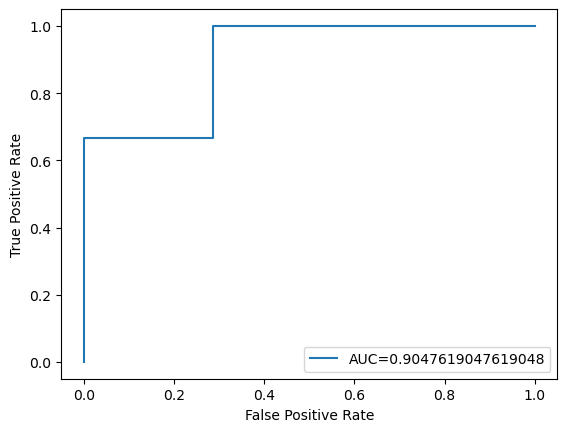

In [304]:
from sklearn import metrics
import matplotlib.pyplot as plt

#convert Actie = True False to 1 or 0
merged.replace({"False": 0, "True": 1}, inplace=True)

#define metrics
fpr, tpr, _ = metrics.roc_curve(merged['Active'],  -merged['minimizedAffinity']) #Use the negative of the score here to rank more negative scores better
auc = metrics.roc_auc_score(merged['Active'],  -merged['minimizedAffinity']) #Also invert the score here too

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [305]:
virtual_screen = merged.copy()
virtual_screen.head()

,ID,Active,Sim,minimizedAffinity,smiles,mol,standardized_mol,canonical_smiles,fingerprint,Molecular_Weight,...,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
1,Molecule_1,1,1.000000,-13.13650,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
0,Molecule_0,1,1.000000,-11.16573,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
7,Molecule_7,0,0.096552,-9.78224,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",422.960,...,422.960,5,3,4.77062,43.18,422.960,5,3,4.77062,43.18
8,Molecule_8,0,0.069930,-8.79919,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",406.320,...,406.320,6,2,4.91050,47.56,406.320,6,2,4.91050,47.56
2,Molecule_2,1,0.098684,-8.72770,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",411.461,...,411.461,5,4,4.85844,91.06,411.461,5,4,4.85844,91.06


In [306]:
virtual_screen.columns

Index(['ID', 'Active', 'Sim', 'minimizedAffinity', 'smiles', 'mol',
       'standardized_mol', 'canonical_smiles', 'fingerprint',
       'Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP',
       'TPSA', 'Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds',
       'ClogP', 'TPSA', 'Molecular_Weight', 'Rotatable_Bonds',
       'Aromatic_Bonds', 'ClogP', 'TPSA'],
      dtype='object')

In [254]:
rep_cluster.columns

Index(['broad_id', 'pert_iname', 'qc_incompatible', 'purity', 'vendor',
       'catalog_no', 'vendor_name', 'expected_mass', 'smiles', 'InChIKey',
       'pubchem_cid', 'deprecated_broad_id', 'mol', 'standardized_mol',
       'canonical_smiles', 'fingerprint', 'Molecular_Weight',
       'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA',
       'fingerprint_cluster', 'property_cluster', 'scaffold',
       'scaffold_cluster', 'fingerprint_cluster_label',
       'property_cluster_label', 'scaffold_cluster_label'],
      dtype='object')

In [258]:
# Step 1: Merge target_ligand into rep_cluster
rep_cluster = pd.concat([rep_cluster, target_ligand], ignore_index=True)

# Step 2: Drop existing cluster columns
cluster_cols = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster', 
                'fingerprint_cluster_label', 'property_cluster_label', 'scaffold_cluster_label']
rep_cluster.drop(columns=[col for col in cluster_cols if col in rep_cluster.columns], inplace=True)

# Step 3: Select molecular descriptors and fingerprints for PCA
descriptor_cols = ['Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA']

# Ensure all feature names are strings
rep_cluster.columns = rep_cluster.columns.astype(str)

# Extract fingerprints if they exist
if 'fingerprint' in rep_cluster.columns:
    rep_cluster = rep_cluster.dropna(subset=['fingerprint'])  # Remove NaN fingerprints
    rep_cluster['fingerprint'] = rep_cluster['fingerprint'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    fingerprint_matrix = pd.DataFrame(rep_cluster['fingerprint'].tolist())
else:
    fingerprint_matrix = pd.DataFrame()

# Merge descriptors with fingerprints if fingerprints exist
if not fingerprint_matrix.empty:
    data_for_pca = pd.concat([rep_cluster[descriptor_cols].reset_index(drop=True), fingerprint_matrix], axis=1)
else:
    data_for_pca = rep_cluster[descriptor_cols]

# Ensure all values are numeric
data_for_pca = data_for_pca.apply(pd.to_numeric, errors='coerce')

# Remove NaN values that might have resulted from missing descriptors
data_for_pca.dropna(inplace=True)

# Ensure feature names are strings (Fix for PCA)
data_for_pca.columns = data_for_pca.columns.astype(str)

In [262]:
# Ensure fingerprint values are in RDKit ExplicitBitVect format and convert them
def convert_fingerprint(fp):
    arr = np.zeros((1,), dtype=int)  # Create an empty NumPy array
    DataStructs.ConvertToNumpyArray(fp, arr)  # Convert RDKit fingerprint to array
    return arr

# Convert all fingerprints
rep_cluster = rep_cluster.dropna(subset=['fingerprint'])  # Remove NaN fingerprints
fingerprint_matrix = rep_cluster['fingerprint'].apply(convert_fingerprint)
fingerprint_matrix = pd.DataFrame(fingerprint_matrix.tolist())  # Convert to DataFrame

print(f"New Fingerprint Matrix Shape: {fingerprint_matrix.shape}")  # Debugging check

New Fingerprint Matrix Shape: (20206, 1024)


In [263]:
# Define descriptor columns
descriptor_cols = ['Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA']

# Convert descriptors to numeric
for col in descriptor_cols:
    rep_cluster[col] = pd.to_numeric(rep_cluster[col], errors='coerce')

# Merge descriptors with fingerprint matrix
data_for_pca = pd.concat([rep_cluster[descriptor_cols].reset_index(drop=True), fingerprint_matrix], axis=1)

# Drop NaN values if any
data_for_pca.dropna(inplace=True)

print(f"Final data_for_pca Shape: {data_for_pca.shape}")  # Debugging check


Final data_for_pca Shape: (20206, 1029)


In [265]:
# Convert all column names to strings
data_for_pca.columns = data_for_pca.columns.astype(str)
# Ensure all values are numeric
data_for_pca = data_for_pca.apply(pd.to_numeric, errors='coerce')

# Drop NaN values if any
data_for_pca.dropna(inplace=True)

# Run PCA only if data is valid
if data_for_pca.shape[0] > 0:
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(data_for_pca)

    # Store PCA results
    rep_cluster.loc[data_for_pca.index, 'PCA_1'] = pca_results[:, 0]
    rep_cluster.loc[data_for_pca.index, 'PCA_2'] = pca_results[:, 1]

    # Perform KMeans clustering
    optimal_clusters = 5  # Adjust as needed
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    rep_cluster.loc[data_for_pca.index, 'Cluster'] = kmeans.fit_predict(data_for_pca)

    print("✅ PCA and Clustering completed successfully!")
else:
    print("❌ Error: Data is still empty after processing!")


✅ PCA and Clustering completed successfully!


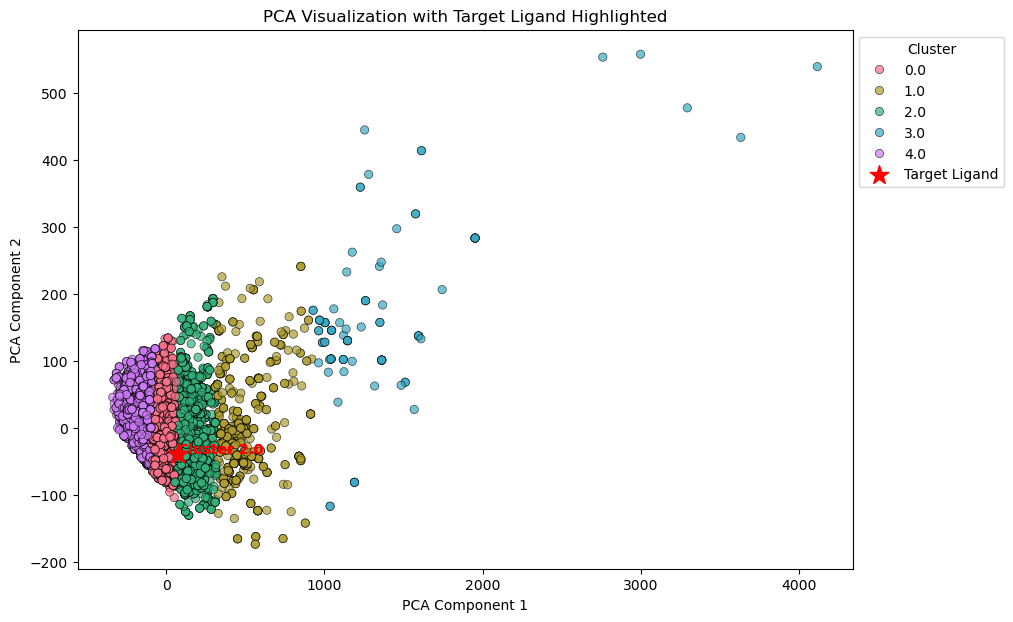

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure distinct colors for each cluster
num_clusters = rep_cluster['Cluster'].nunique()
palette = sns.color_palette("husl", num_clusters)

# Create scatter plot for clusters
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=rep_cluster['PCA_1'],
    y=rep_cluster['PCA_2'],
    hue=rep_cluster['Cluster'],
    palette=palette,
    edgecolor='black',
    alpha=0.7
)

# Identify target_ligand's PCA location
target_pca = rep_cluster.loc[rep_cluster['pubchem_cid'].isin(target_ligand['pubchem_cid'])]

# Plot target_ligand as a red star marker
plt.scatter(
    target_pca['PCA_1'],
    target_pca['PCA_2'],
    color='red',
    marker='*',
    s=200,
    label="Target Ligand"
)

# Add cluster label for target_ligand
for _, row in target_pca.iterrows():
    plt.text(row['PCA_1'], row['PCA_2'], f"Cluster {row['Cluster']}", fontsize=10, color='red', weight='bold')

# Plot settings
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization with Target Ligand Highlighted")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1, 1))
plt.show()


In [280]:
# Filter rep_cluster for only Cluster 2
cluster_2_df = rep_cluster[rep_cluster['Cluster'] == 2]
print(cluster_2_df.shape)
cluster_2_df.head()

(4944, 25)


,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,scaffold,PCA_1,PCA_2,Cluster
54,BRD-K06817181-001-02-3,"1,2,3,4,5,6-hexabromocyclohexane",0.0,0.00,Tocris,2291,"1,2,3,4,5,6-Hexabromocyclohexane",551.557,BrC1C(Br)C(Br)C(Br)C(Br)C1Br,QFQZKISCBJKVHI-UHFFFAOYSA-N,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",557.538,0.0,0.0,4.5810,0.00,C1CCCCC1,142.235308,-130.228490,2.0
55,BRD-K06817181-001-03-9,"1,2,3,4,5,6-hexabromocyclohexane",0.0,38.29,Tocris,2291,"1,2,3,4,5,6-Hexabromocyclohexane",551.557,BrC1C(Br)C(Br)C(Br)C(Br)C1Br,QFQZKISCBJKVHI-UHFFFAOYSA-N,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",557.538,0.0,0.0,4.5810,0.00,C1CCCCC1,142.235308,-130.228490,2.0
56,BRD-K06817181-001-03-9,"1,2,3,4,5,6-hexabromocyclohexane",0.0,0.00,Tocris,2291,"1,2,3,4,5,6-Hexabromocyclohexane",551.557,BrC1C(Br)C(Br)C(Br)C(Br)C1Br,QFQZKISCBJKVHI-UHFFFAOYSA-N,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",557.538,0.0,0.0,4.5810,0.00,C1CCCCC1,142.235308,-130.228490,2.0
60,BRD-K53083666-001-01-0,"1,5-dicaffeoylquinic-acid",0.0,0.00,AnalytiCon,NP-000244,NaN,516.127,O[C@@H]1C[C@@](C[C@@H](OC(=O)\C=C\c2ccc(O)c(O)...,YDDUMTOHNYZQPO-PSEXTPKNSA-N,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",516.455,7.0,2.0,1.0296,211.28,O=C(C=Cc1ccccc1)OC1CCCC(OC(=O)C=Cc2ccccc2)C1,161.795198,84.075434,2.0
61,BRD-K53083666-001-02-9,"1,5-dicaffeoylquinic-acid",0.0,95.94,MedChemEx,HY-N1412,"1,3-Dicaffeoylquinic acid",516.127,O[C@@H]1C[C@@](C[C@@H](OC(=O)\C=C\c2ccc(O)c(O)...,YDDUMTOHNYZQPO-PSEXTPKNSA-N,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",516.455,7.0,2.0,1.0296,211.28,O=C(C=Cc1ccccc1)OC1CCCC(OC(=O)C=Cc2ccccc2)C1,161.795198,84.075434,2.0


In [289]:
# Step 1: Extract only Cluster 2 from the first PCA clustering
cluster_2_df = rep_cluster[rep_cluster['Cluster'] == 2].copy()

# Step 2: Define molecular descriptor columns
descriptor_cols = ['Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA']

# Convert descriptors to numeric
for col in descriptor_cols:
    cluster_2_df.loc[:, col] = pd.to_numeric(cluster_2_df[col], errors='coerce')

# Step 3: Convert RDKit ExplicitBitVect fingerprints into a binary feature matrix
def convert_fingerprint(fp):
    arr = np.zeros((1,), dtype=int)  # Create an empty NumPy array
    DataStructs.ConvertToNumpyArray(fp, arr)  # Convert RDKit fingerprint to array
    return arr

# Apply fingerprint conversion
fingerprint_matrix = cluster_2_df['fingerprint'].apply(convert_fingerprint)
fingerprint_matrix = pd.DataFrame(fingerprint_matrix.tolist(), index=cluster_2_df.index)

# Step 4: Merge descriptors with fingerprint matrix
data_for_pca = pd.concat([cluster_2_df[descriptor_cols], fingerprint_matrix], axis=1)

# Drop NaN values
data_for_pca.dropna(inplace=True)

# Ensure all column names are strings
data_for_pca.columns = data_for_pca.columns.astype(str)

# Step 5: Perform PCA (reduce to 2D)
if data_for_pca.shape[0] > 0:
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(data_for_pca)

    # Add PCA results back to cluster_2_df
    cluster_2_df.loc[data_for_pca.index, 'PCA_1'] = pca_results[:, 0]
    cluster_2_df.loc[data_for_pca.index, 'PCA_2'] = pca_results[:, 1]

    # Step 6: Perform KMeans clustering within Cluster 2
    optimal_clusters = 5  # Adjust based on need
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_2_df.loc[data_for_pca.index, 'Sub_Cluster'] = kmeans.fit_predict(data_for_pca)

    print("✅ PCA and re-clustering completed within Cluster 2!")

else:
    print("❌ Error: No valid data after processing.")

✅ PCA and re-clustering completed within Cluster 2!


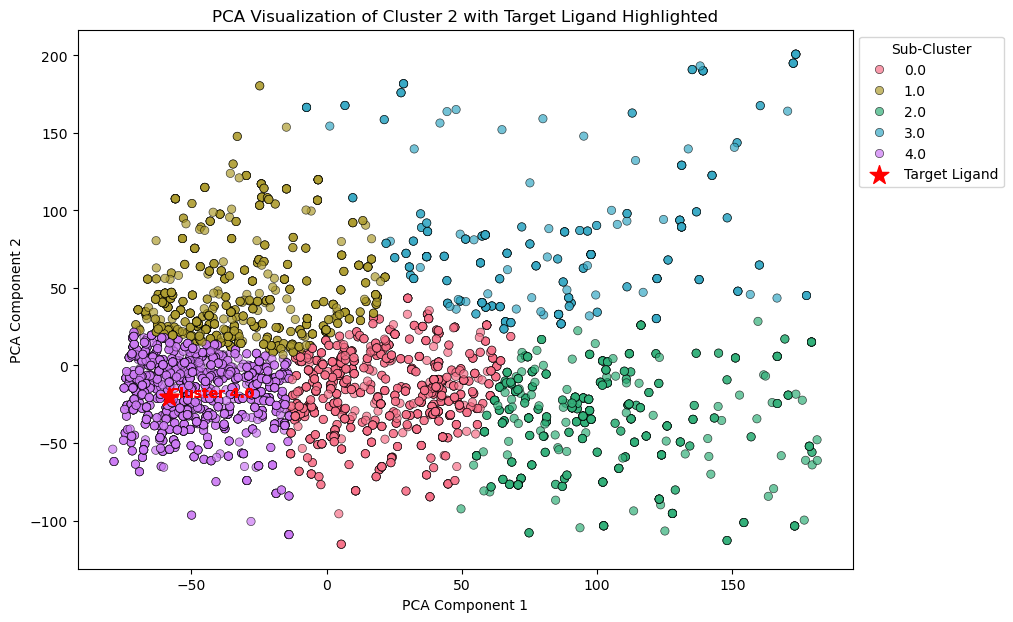

In [290]:
# Ensure distinct colors for each sub-cluster
num_clusters = cluster_2_df['Sub_Cluster'].nunique()
palette = sns.color_palette("husl", num_clusters)

# Create scatter plot for sub-clusters
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=cluster_2_df['PCA_1'],
    y=cluster_2_df['PCA_2'],
    hue=cluster_2_df['Sub_Cluster'],
    palette=palette,
    edgecolor='black',
    alpha=0.7
)

# Identify `target_ligand` location within Cluster 2
target_pca = cluster_2_df.loc[cluster_2_df['pubchem_cid'].isin(target_ligand['pubchem_cid'])]

# Plot target_ligand as a red star marker
plt.scatter(
    target_pca['PCA_1'],
    target_pca['PCA_2'],
    color='red',
    marker='*',
    s=200,
    label="Target Ligand"
)

# Add text labels for the `target_ligand` cluster
for _, row in target_pca.iterrows():
    plt.text(row['PCA_1'], row['PCA_2'], f"Cluster {row['Sub_Cluster']}", fontsize=10, color='red', weight='bold')

# Plot settings
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Cluster 2 with Target Ligand Highlighted")
plt.legend(title="Sub-Cluster", loc="best", bbox_to_anchor=(1, 1))
plt.show()

In [293]:
cluster_4_df = cluster_2_df[cluster_2_df['Sub_Cluster'] == 4]
print(cluster_4_df.shape)
cluster_4_df.head()

(1740, 26)


,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,scaffold,PCA_1,PCA_2,Cluster,Sub_Cluster
269,BRD-K57796080-001-03-7,"3,5-DHPG-(S)",0.0,0.00,Tocris,805,"(S)-3,5-DHPG",183.053,N[C@H](C(O)=O)c1cc(O)cc(O)c1,HOOWCUZPEFNHDT-ZETCQYMHSA-N,...,503.593,8.0,3.0,5.2688,43.86,c1ccccc1,-31.368531,-56.534580,2.0,4.0
270,BRD-K45662124-050-02-3,3'-fluorobenzylspiperone,0.0,93.86,Tocris,701,3'-Fluorobenzylspiperone maleate,503.238,Fc1ccc(cc1)C(=O)CCCN1CCC2(CC1)N(CN(Cc1cccc(F)c...,DXZKTRNEOISOCA-UHFFFAOYSA-N,...,503.593,8.0,3.0,5.2688,43.86,O=C(CCCN1CCC2(CC1)C(=O)N(Cc1ccccc1)CN2c1ccccc1...,-31.369955,-56.540066,2.0,4.0
271,BRD-K45662124-050-03-9,3'-fluorobenzylspiperone,0.0,93.33,Tocris,701,3'-Fluorobenzylspiperone maleate,503.238,Fc1ccc(cc1)C(=O)CCCN1CCC2(CC1)N(CN(Cc1cccc(F)c...,DXZKTRNEOISOCA-UHFFFAOYSA-N,...,503.593,8.0,3.0,5.2688,43.86,O=C(CCCN1CCC2(CC1)C(=O)N(Cc1ccccc1)CN2c1ccccc1...,-31.369955,-56.540066,2.0,4.0
272,BRD-K45662124-050-03-9,3'-fluorobenzylspiperone,0.0,92.90,Tocris,701,3'-Fluorobenzylspiperone maleate,503.238,Fc1ccc(cc1)C(=O)CCCN1CCC2(CC1)N(CN(Cc1cccc(F)c...,DXZKTRNEOISOCA-UHFFFAOYSA-N,...,503.593,8.0,3.0,5.2688,43.86,O=C(CCCN1CCC2(CC1)C(=O)N(Cc1ccccc1)CN2c1ccccc1...,-31.369955,-56.540066,2.0,4.0
425,BRD-K01825667-050-01-9,7-hydroxy-PIPAT,0.0,54.71,Tocris,719,7-Hydroxy-PIPAT maleate,487.086,CCCN(C\C=C\I)[C@H]1CCc2ccc(O)cc2C1 |&1:8|,RTMIJLQPWFKAFE-GZTQLTBSSA-N,...,482.540,2.0,5.0,3.8449,89.68,c1ccc2c(c1)CCCC2,-36.635134,-6.357742,2.0,4.0


In [294]:
# Step 1: Extract only Sub-Cluster 1 from Cluster 2
cluster_4_df = cluster_2_df[cluster_2_df['Sub_Cluster'] == 4].copy()

# Step 2: Define molecular descriptor columns
descriptor_cols = ['Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA']

# Convert descriptors to numeric
for col in descriptor_cols:
    cluster_4_df.loc[:, col] = pd.to_numeric(cluster_4_df[col], errors='coerce')

# Step 3: Convert RDKit ExplicitBitVect fingerprints into a binary feature matrix
def convert_fingerprint(fp):
    arr = np.zeros((1,), dtype=int)  # Create an empty NumPy array
    DataStructs.ConvertToNumpyArray(fp, arr)  # Convert RDKit fingerprint to array
    return arr

# Apply fingerprint conversion
fingerprint_matrix = cluster_4_df['fingerprint'].apply(convert_fingerprint)
fingerprint_matrix = pd.DataFrame(fingerprint_matrix.tolist(), index=cluster_4_df.index)

# Step 4: Merge descriptors with fingerprint matrix
data_for_pca = pd.concat([cluster_4_df[descriptor_cols], fingerprint_matrix], axis=1)

# Drop NaN values
data_for_pca.dropna(inplace=True)

# Ensure all column names are strings
data_for_pca.columns = data_for_pca.columns.astype(str)

# Step 5: Perform PCA (reduce to 2D)
if data_for_pca.shape[0] > 0:
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(data_for_pca)

    # Add PCA results back to cluster_1_df
    cluster_4_df.loc[data_for_pca.index, 'PCA_1'] = pca_results[:, 0]
    cluster_4_df.loc[data_for_pca.index, 'PCA_2'] = pca_results[:, 1]

    # Step 6: Perform KMeans clustering within Cluster 1
    optimal_clusters = 5  # Adjust based on need
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_4_df.loc[data_for_pca.index, 'Final_Cluster'] = kmeans.fit_predict(data_for_pca)

    print("✅ PCA and re-clustering completed within Cluster 1!")

else:
    print("❌ Error: No valid data after processing.")

✅ PCA and re-clustering completed within Cluster 1!


s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


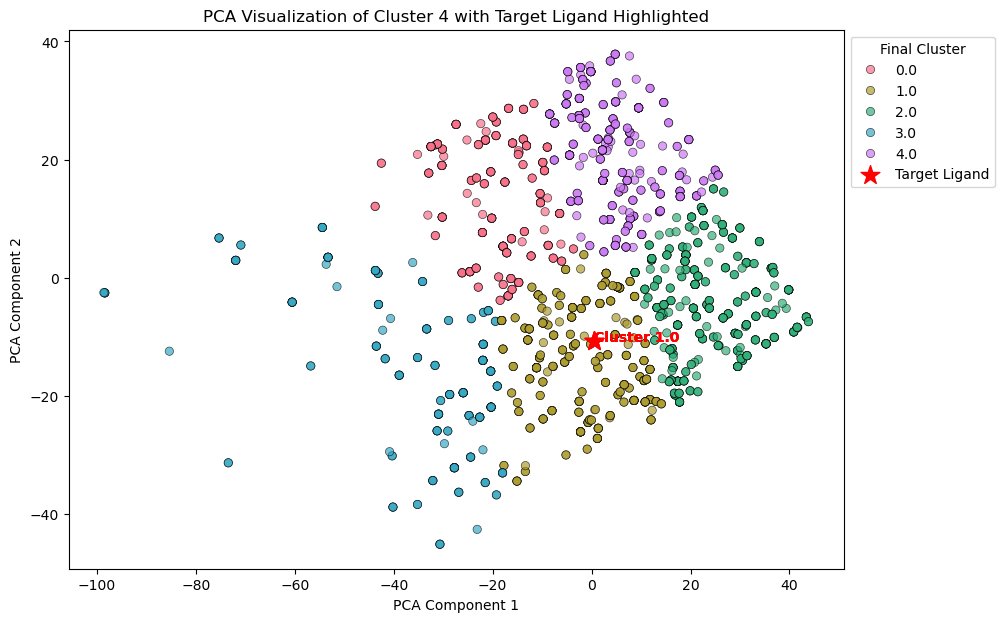

In [297]:
# Ensure distinct colors for each final cluster
num_clusters = cluster_4_df['Final_Cluster'].nunique()
palette = sns.color_palette("husl", num_clusters)

# Create scatter plot for final clusters
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=cluster_4_df['PCA_1'],
    y=cluster_4_df['PCA_2'],
    hue=cluster_4_df['Final_Cluster'],
    palette=palette,
    edgecolor='black',
    alpha=0.7
)

# Identify `target_ligand` location within Cluster 1
target_pca = cluster_4_df.loc[cluster_4_df['pubchem_cid'].isin(target_ligand['pubchem_cid'])]

# Plot target_ligand as a red star marker
plt.scatter(
    target_pca['PCA_1'],
    target_pca['PCA_2'],
    color='red',
    marker='*',
    s=200,
    label="Target Ligand"
)

# Add text labels for the `target_ligand` cluster
for _, row in target_pca.iterrows():
    plt.text(row['PCA_1'], row['PCA_2'], f"Cluster {row['Final_Cluster']}", fontsize=10, color='red', weight='bold')

# Plot settings
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Cluster 4 with Target Ligand Highlighted")
plt.legend(title="Final Cluster", loc="best", bbox_to_anchor=(1, 1))
plt.show()

In [298]:
reduced_df = cluster_4_df[cluster_4_df['Final_Cluster'] == 1]

print(reduced_df.shape)
reduced_df.head()

(407, 27)


,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,scaffold,PCA_1,PCA_2,Cluster,Sub_Cluster,Final_Cluster
595,BRD-K22749967-046-02-3,ABT-239,0.0,99.38,Axon,1510,NaN,330.173,C[C@@H]1CCCN1CCc1cc2cc(ccc2o1)-c1ccc(cc1)C#N,KFHYZKCRXNRKRC-MRXNPFEDSA-N,...,4.0,5.0,4.62382,73.02,c1ccc(-c2ccc3oc(CCN4CCCC4)cc3c2)cc1,-5.255367,1.401732,2.0,4.0,1.0
596,BRD-K97233161-003-01-5,ABT-491,0.0,93.81,EMDBio,511071-2MG,"PAF Receptor Antagonist, ABT-491",479.176,CN(C)C(=O)n1cc(C(=O)c2ccc(Cn3c(C)nc4cnccc34)c(...,GDLNHSUSOZEAOR-UHFFFAOYSA-N,...,4.0,5.0,4.62382,73.02,O=C(c1ccc(Cn2cnc3cnccc32)cc1)c1c[nH]c2ccccc12,-5.258447,1.403648,2.0,4.0,1.0
597,BRD-K97233161-003-01-5,ABT-491,0.0,93.16,EMDBio,511071-2MG,"PAF Receptor Antagonist, ABT-491",479.176,CN(C)C(=O)n1cc(C(=O)c2ccc(Cn3c(C)nc4cnccc34)c(...,GDLNHSUSOZEAOR-UHFFFAOYSA-N,...,4.0,5.0,4.62382,73.02,O=C(c1ccc(Cn2cnc3cnccc32)cc1)c1c[nH]c2ccccc12,-5.258447,1.403648,2.0,4.0,1.0
598,BRD-K97233161-003-02-3,ABT-491,0.0,92.38,SantaCruz,sc-214459,ABT-491 hydrochloride,479.176,CN(C)C(=O)n1cc(C(=O)c2ccc(Cn3c(C)nc4cnccc34)c(...,GDLNHSUSOZEAOR-UHFFFAOYSA-N,...,4.0,2.0,3.33920,69.72,O=C(c1ccc(Cn2cnc3cnccc32)cc1)c1c[nH]c2ccccc12,7.602496,-18.660587,2.0,4.0,1.0
599,BRD-K11792081-001-01-4,ABT-639,0.0,96.16,MedChemEx,HY-19721,ABT-639,455.088,Fc1ccccc1NS(=O)(=O)c1cc(C(=O)N2CCN3CCC[C@@H]3C...,AGPIHNZOZNKRGT-CYBMUJFWSA-N,...,4.0,2.0,3.33920,69.72,O=C(c1cccc(S(=O)(=O)Nc2ccccc2)c1)N1CCN2CCCC2C1,7.605150,-18.661919,2.0,4.0,1.0


In [307]:
virtual_screen

,ID,Active,Sim,minimizedAffinity,smiles,mol,standardized_mol,canonical_smiles,fingerprint,Molecular_Weight,...,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
1,Molecule_1,1,1.000000,-13.13650,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x0000017411A...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
0,Molecule_0,1,1.000000,-11.16573,O=C5NCc4c2c3n(c1ccccc12)C8(OC(n6c3c(c45)c7cccc...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",466.541,...,466.541,2,5,4.35400,69.45,466.541,2,5,4.35400,69.45
7,Molecule_7,0,0.096552,-9.78224,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,Cc1cccc(NC(=O)c2ccccc2NC(=O)C(=O)c2c(C)[nH]c3c...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",422.960,...,422.960,5,3,4.77062,43.18,422.960,5,3,4.77062,43.18
8,Molecule_8,0,0.069930,-8.79919,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(C)[C@H]1CC[C@@H](C)C[C@@H]1OC(=O)COC(=O)c1c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",406.320,...,406.320,6,2,4.91050,47.56,406.320,6,2,4.91050,47.56
2,Molecule_2,1,0.098684,-8.72770,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(=O)Nc1cc(Oc2ccc3c(c2)nc(Nc2cccc(C(C)(C)C)c2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",411.461,...,411.461,5,4,4.85844,91.06,411.461,5,4,4.85844,91.06
9,Molecule_9,0,0.092105,-8.38252,CC(C)n1c(S[C@@H](C)C(=O)Nc2nccs2)nnc1-c1cc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC(C)n1c(S[C@@H](C)C(=O)Nc2nccs2)nnc1-c1cc2ccc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",418.990,...,418.990,9,2,4.76410,49.41,418.990,9,2,4.76410,49.41
6,Molecule_6,0,0.063830,-8.33226,O=C(NC(=S)n1nc(Nc2ccccc2)cc1Nc1ccccc1)c1ccco1,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,O=C(NC(=S)n1nc(Nc2ccccc2)cc1Nc1ccccc1)c1ccco1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",403.467,...,403.467,5,4,4.52630,84.12,403.467,5,4,4.52630,84.12
3,Molecule_3,0,0.099338,-8.31514,Cc1nccn1[C@H]1C[C@H]2CN(Cc3cccc(Cl)c3)C[C@H]2C...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,Cc1nccn1[C@H]1C[C@H]2CN(Cc3cccc(Cl)c3)C[C@H]2C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",402.409,...,402.409,6,1,4.74600,61.83,402.409,6,1,4.74600,61.83
5,Molecule_5,0,0.070423,-8.15975,COCc1cccc(NC(=O)COc2ccc(C(C)(C)C)cc2Br)c1,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,COCc1cccc(NC(=O)COc2ccc(C(C)(C)C)cc2Br)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",413.528,...,413.528,6,4,4.84800,85.84,413.528,6,4,4.84800,85.84
4,Molecule_4,0,0.055556,-8.04509,CC[C@@H](C(=O)NC(C)C)N(Cc1ccccc1Cl)C(=O)CSc1cc...,<rdkit.Chem.rdchem.Mol object at 0x00000174336...,<rdkit.Chem.rdchem.Mol object at 0x000001741D8...,CC[C@@H](C(=O)NC(C)C)N(Cc1ccccc1Cl)C(=O)CSc1cc...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",429.524,...,429.524,5,4,5.76010,81.07,429.524,5,4,5.76010,81.07


## Modeling

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Stephen\AppData\Local\Temp\ipykernel_26492\3430668699.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['Predicted_Probability'] = rf_model.predict_proba(X_reduced)[:, 1]


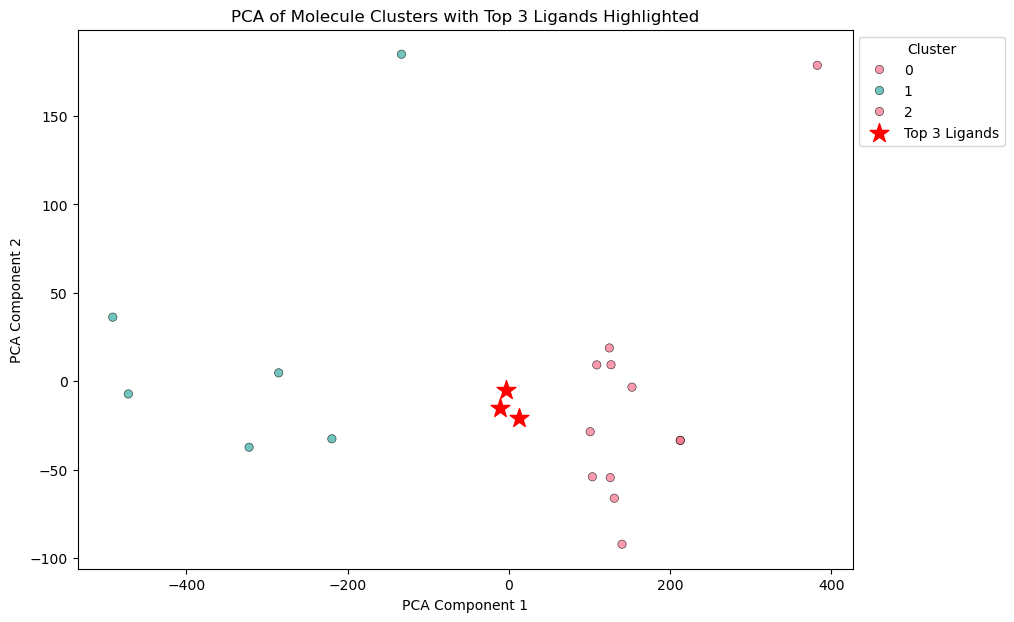

In [327]:
import numpy as np
import pandas as pd
from rdkit import DataStructs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Prepare Positive and Negative Examples
# Use all of `virtual_screen` as positive examples (ignore 'Active' column)
positive_examples = virtual_screen.copy()

# Sample 8 random negative examples from `alz_lib`
negative_examples = alz_lib.sample(n=8, random_state=42)

# ✅ Step 2: Convert Fingerprints to Numeric Features for Both Datasets
def convert_fingerprint(fp):
    arr = np.zeros((1,), dtype=int)  # Create empty NumPy array
    DataStructs.ConvertToNumpyArray(fp, arr)  # Convert RDKit fingerprint to array
    return arr

# Apply conversion to fingerprints in both datasets
positive_examples = positive_examples.dropna(subset=['fingerprint'])
negative_examples = negative_examples.dropna(subset=['fingerprint'])

positive_fingerprint_matrix = positive_examples['fingerprint'].apply(convert_fingerprint)
negative_fingerprint_matrix = negative_examples['fingerprint'].apply(convert_fingerprint)

positive_fingerprint_matrix = pd.DataFrame(positive_fingerprint_matrix.tolist(), index=positive_examples.index)
negative_fingerprint_matrix = pd.DataFrame(negative_fingerprint_matrix.tolist(), index=negative_examples.index)

# ✅ Step 3: Prepare Training Data
descriptor_cols = ['Molecular_Weight', 'Rotatable_Bonds', 'Aromatic_Bonds', 'ClogP', 'TPSA']

# Merge descriptors and fingerprints
X_positive = pd.concat([positive_examples[descriptor_cols], positive_fingerprint_matrix], axis=1)
X_negative = pd.concat([negative_examples[descriptor_cols], negative_fingerprint_matrix], axis=1)

# Assign labels: 1 for positive, 0 for negative
X_positive['Label'] = 1
X_negative['Label'] = 0

# Combine positive and negative examples into training dataset
training_data = pd.concat([X_positive, X_negative], ignore_index=True)

# Ensure all values are numeric
training_data = training_data.apply(pd.to_numeric, errors='coerce')
training_data.dropna(inplace=True)

# Convert all feature names to strings
training_data.columns = training_data.columns.astype(str)

# ✅ Step 4: Split Data for Training & Testing
X = training_data.drop(columns=['Label'])
y = training_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 5: Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,  # Prevents overfitting
    min_samples_split=5, 
    min_samples_leaf=3, 
    random_state=42, 
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# ✅ Step 6: Perform PCA for Visualization
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

# Add PCA results to dataframe
training_data['PCA_1'] = pca_results[:, 0]
training_data['PCA_2'] = pca_results[:, 1]

# ✅ Step 7: Cluster Data for Visualization
optimal_clusters = 3  # Adjust if needed
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
training_data['Cluster'] = kmeans.fit_predict(X)

# ✅ Step 8: Apply Model to `reduced_df`
# Convert fingerprints in `reduced_df` the same way
reduced_fingerprint_matrix = reduced_df['fingerprint'].apply(convert_fingerprint)
reduced_fingerprint_matrix = pd.DataFrame(reduced_fingerprint_matrix.tolist(), index=reduced_df.index)

# Merge descriptors with fingerprint matrix
X_reduced = pd.concat([reduced_df[descriptor_cols], reduced_fingerprint_matrix], axis=1)
X_reduced = X_reduced.apply(pd.to_numeric, errors='coerce')
X_reduced.dropna(inplace=True)

# Convert feature names to strings and ensure order matches training data
X_reduced.columns = X_reduced.columns.astype(str)
X_reduced = X_reduced[X_train.columns]

# ✅ Step 9: Predict probabilities on reduced_df
reduced_df['Predicted_Probability'] = rf_model.predict_proba(X_reduced)[:, 1]

# ✅ Step 10: Get Top 3 Most Likely Good Ligands
top_3_ligands = reduced_df.drop_duplicates(subset=['pubchem_cid']).nlargest(3, 'Predicted_Probability')

# ✅ Step 11: Visualize PCA Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=training_data['PCA_1'],
    y=training_data['PCA_2'],
    hue=training_data['Cluster'],
    palette="husl",
    edgecolor='black',
    alpha=0.7
)

# Highlight the top 3 predicted ligands
top_3_pca = reduced_df.loc[top_3_ligands.index, ['PCA_1', 'PCA_2']]
plt.scatter(
    top_3_pca['PCA_1'], 
    top_3_pca['PCA_2'], 
    color='red', 
    marker='*', 
    s=200, 
    label="Top 3 Ligands"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Molecule Clusters with Top 3 Ligands Highlighted")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1, 1))
plt.show()


In [329]:
top_3_ligands

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,...,Aromatic_Bonds,ClogP,TPSA,scaffold,PCA_1,PCA_2,Cluster,Sub_Cluster,Final_Cluster,Predicted_Probability
2604,BRD-K14329163-001-03-9,BAY-K-8644-(s)-(-),0.0,90.62,Tocris,1546,(S)-(-)-Bay K 8644,356.098,COC(=O)C1=C(C)NC(C)=C([C@H]1c1ccccc1C(F)(F)F)[...,ZFLWDHHVRRZMEI-ZDUSSCGKSA-N,...,4.0,6.33102,57.86,C1=CC(c2ccccc2)C=CN1,-11.133347,-15.210795,2.0,4.0,1.0,0.650518
15485,BRD-A08187463-001-12-9,racecadotril,0.0,99.40,MicroSource,1502331,RACECADOTRIL,385.135,CC(=O)SC[C@@H](Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc...,ODUOJXZPIYUATO-LJQANCHMSA-N,...,4.0,6.07520,70.00,O=C(CCc1ccccc1)NCC(=O)OCc1ccccc1,-3.853064,-5.054411,2.0,4.0,1.0,0.650183
4053,BRD-K02213468-001-02-3,CDPPB,0.0,96.82,Tocris,3235,CDPPB,364.132,O=C(Nc1cc(nn1-c1ccccc1)-c1ccccc1)c1cccc(c1)C#N,BKUIZWILNWHFHD-UHFFFAOYSA-N,...,4.0,5.22422,72.50,O=C(Nc1cc(-c2ccccc2)nn1-c1ccccc1)c1ccccc1,13.048062,-20.941412,2.0,4.0,1.0,0.648087


In [330]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# ✅ Step 1: Predict on Test Data
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# ✅ Step 2: Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ✅ Step 3: Print Results
print("🔹 Random Forest Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


🔹 Random Forest Model Performance:
Accuracy: 0.7500
ROC-AUC Score: 1.0000

Confusion Matrix:
[[1 1]
 [0 2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

